Aluno: Bruno Ricardo Pereira dos Santos Santos 

Nº USP: 10288640

In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime

from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.utils import np_utils, to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

In [2]:
!git clone https://github.com/karolpiczak/ESC-50

Cloning into 'ESC-50'...
remote: Enumerating objects: 4163, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 4163 (delta 16), reused 0 (delta 0), pack-reused 4136
Receiving objects: 100% (4163/4163), 878.78 MiB | 11.88 MiB/s, done.
Resolving deltas: 100% (263/263), done.
Checking out files: 100% (2011/2011), done.


# Problema

Peguei dados da base acima e selecionei duas classes,  breathing e snoring. Achei interessante essas duas classes pois há vários aplicativos de celular para monitoramento de sono que indicam se a pessoa ronca ou não e quero verificar se esses apps conseguem realmente classificar corretamente. Sendo assim, importei os dados, os transformei e extraí padrões usando modelos de machine learning e CNN.

# Obtenção e processamento dos dados

In [3]:

import pandas as pd
legenda = pd.read_csv('ESC-50/meta/esc50.csv')

legenda1 = legenda[legenda['category']=='breathing']
legenda2 = legenda[legenda['category']=='snoring']

b_wav_files = legenda1['filename']
s_wav_files = legenda2['filename']

legenda2.head()

,filename,fold,target,category,esc10,src_file,take
97,1-20545-A-28.wav,1,28,snoring,False,20545,A
144,1-27403-A-28.wav,1,28,snoring,False,27403,A
145,1-27405-A-28.wav,1,28,snoring,False,27405,A
198,1-39937-A-28.wav,1,28,snoring,False,39937,A
200,1-40621-A-28.wav,1,28,snoring,False,40621,A


In [ ]:
#from os import listdir
#from os.path import isfile, join
#b_wav_files = [f for f in listdir('ESC-50/audio/') if f == '1-52323-A-24.wav']
#c_wav_files = [f for f in listdir('ESC-50/audio/') if f in legenda2['filename']]
b_wav_files 

In [5]:
import librosa

def get_mel_spectrogram(file_path, max_padding=0, n_fft=2048, hop_length=512, n_mels=128):
    try:
        # Load audio file
        y, sr = librosa.load(file_path)

        # Normalize audio data between -1 and 1
        normalized_y = librosa.util.normalize(y)

        # Generate mel scaled filterbanks
        mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)

        # Convert sound intensity to log amplitude:
        mel_db = librosa.amplitude_to_db(abs(mel))

        # Normalize between -1 and 1
        normalized_mel = librosa.util.normalize(mel_db)

        # Should we require padding
        shape = normalized_mel.shape[1]
        if (max_padding > 0 & shape < max_padding):
            xDiff = max_padding - shape
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            normalized_mel = np.pad(normalized_mel, pad_width=((0,0), (xLeft, xRight)), mode='constant')

    except Exception as e:
        print("Error parsing wavefile: ", e)
        return None 
    return normalized_mel

In [ ]:
features = []
labels = []
frames_max = 0
counter = 0
total_samples = len(b_wav_files)+len(s_wav_files)
n_mels=40


for b_wav_file in b_wav_files:
    file_path = 'ESC-50/audio/'+b_wav_file
    class_label = 'breathing'

    # Extract Log-Mel Spectrograms (do not add padding)
    print(file_path)
    mels = get_mel_spectrogram(file_path, 0, n_mels=n_mels)
    
    # Save current frame count
    num_frames = mels.shape[1]
    
    # Add row (feature / label)
    features.append(mels)
    labels.append(class_label)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames

for s_wav_file in s_wav_files:
    file_path = 'ESC-50/audio/'+s_wav_file
    class_label = 'snoring'

    # Extract Log-Mel Spectrograms (do not add padding)
    print(file_path)
    mels = get_mel_spectrogram(file_path, 0, n_mels=n_mels)
    
    # Save current frame count
    num_frames = mels.shape[1]
    
    # Add row (feature / label)
    features.append(mels)
    labels.append(class_label)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames

In [7]:
melspec = get_mel_spectrogram('ESC-50/audio/5-251489-A-24.wav')
melspec.shape

(128, 216)

In [8]:
melspec = get_mel_spectrogram('ESC-50/audio/5-251489-A-24.wav')
melspec.shape

(128, 216)

In [9]:
# Given an numpy array of features, zero-pads each ocurrence to max_padding
def add_padding(features, max_padding=174):
    padded = []

    # Add padding
    for i in range(len(features)):
        px = features[i]
        size = len(px[0])
        # Add padding if required
        if (size < max_padding):
            xDiff = max_padding - size
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            px = np.pad(px, pad_width=((0,0), (xLeft, xRight)), mode='constant')
        
        padded.append(px)

    return padded

In [10]:
padded_features = add_padding(features, frames_max)

In [11]:
X = np.array(padded_features)
y = np.array(labels)

In [12]:
X.shape

(80, 40, 216)

# SVC e MLP classifier

In [13]:
X_ = X.reshape(80,8640)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_,y,test_size=0.25, random_state=42)

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

clf = SVC(random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)

predictions_2 = list(clf.predict(X_test))

print('Accuracy score: {}'.format(accuracy_score(y_test, predictions_2)))
print('Precision score: {}'.format(precision_score(y_test, predictions_2,pos_label='breathing')))
print('Recall score: {}'.format(recall_score(y_test, predictions_2,pos_label='breathing')))
print('F1 score: {}'.format(f1_score(y_test, predictions_2,pos_label='breathing')))

Accuracy score: 0.85
Precision score: 1.0
Recall score: 0.7272727272727273
F1 score: 0.8421052631578948


In [16]:
print('Precision score: {}'.format(precision_score(y_test, predictions_2,pos_label='snoring')))
print('Recall score: {}'.format(recall_score(y_test, predictions_2,pos_label='snoring')))
print('F1 score: {}'.format(f1_score(y_test, predictions_2,pos_label='snoring')))

Precision score: 0.75
Recall score: 1.0
F1 score: 0.8571428571428571


In [17]:
ra1 = classification_report(y_test, predictions_2, labels=['snoring','breathing'], target_names=['snoring','breathing'])

print(ra1)

              precision    recall  f1-score   support

     snoring       0.75      1.00      0.86         9
   breathing       1.00      0.73      0.84        11

    accuracy                           0.85        20
   macro avg       0.88      0.86      0.85        20
weighted avg       0.89      0.85      0.85        20



In [18]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=42, max_iter=300).fit(X_train, y_train)
clf.score(X_test, y_test)

predictions_1 = list(clf.predict(X_test))

print('Accuracy score: {}'.format(accuracy_score(y_test, predictions_1)))
print('Precision score: {}'.format(precision_score(y_test, predictions_1,pos_label='breathing')))
print('Recall score: {}'.format(recall_score(y_test, predictions_1,pos_label='breathing')))
print('F1 score: {}'.format(f1_score(y_test, predictions_1,pos_label='breathing')))

Accuracy score: 0.55
Precision score: 0.5714285714285714
Recall score: 0.7272727272727273
F1 score: 0.64


In [19]:
print('Precision score: {}'.format(precision_score(y_test, predictions_1,pos_label='snoring')))
print('Recall score: {}'.format(recall_score(y_test, predictions_1,pos_label='snoring')))
print('F1 score: {}'.format(f1_score(y_test, predictions_1,pos_label='snoring')))

Precision score: 0.5
Recall score: 0.3333333333333333
F1 score: 0.4


In [20]:
ra2 = classification_report(y_test, predictions_1, labels=['snoring','breathing'], target_names=['snoring','breathing'])

print(ra2)

              precision    recall  f1-score   support

     snoring       0.50      0.33      0.40         9
   breathing       0.57      0.73      0.64        11

    accuracy                           0.55        20
   macro avg       0.54      0.53      0.52        20
weighted avg       0.54      0.55      0.53        20



# CNN

In [21]:
np.save("X-mel_spec", X)
np.save("y-mel_spec", y)

In [22]:
indexes = []
total = total_samples
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 25                        # 30 dados de treino 10 de teste
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Print status
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

X test shape: (20, 40, 216) 	 X train shape: (60, 40, 216)
y test shape: (20,) 		 y train shape: (60,)


In [23]:
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

In [24]:
y_test_encoded

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [25]:
# How data should be structured
num_rows = 40
num_columns = 216
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

In [26]:
X_train.shape

(60, 40, 216, 1)

In [27]:
def create_model():

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model


model = create_model()

In [28]:
model.compile(
    loss='binary_crossentropy',  # duas classes
    metrics=['accuracy'],  
    optimizer='adam')

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 214, 32)       320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 38, 214, 32)       0         
                                                                 
 batch_normalization (BatchN  (None, 38, 214, 32)      128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 212, 32)       9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 36, 212, 32)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 36, 212, 32)      128       
 hNormalization)                                        

In [29]:
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=4, 
                    epochs=50, 
                    validation_data=(X_test,y_test_encoded),
                    verbose=1)

Epoch 1/50
15/15 [==============================] - 11s 32ms/step - loss: 0.5689 - accuracy: 0.7000 - val_loss: 0.6655 - val_accuracy: 0.6000
Epoch 2/50
15/15 [==============================] - 0s 13ms/step - loss: 0.4389 - accuracy: 0.8167 - val_loss: 0.6859 - val_accuracy: 0.6000
Epoch 3/50
15/15 [==============================] - 0s 13ms/step - loss: 0.4431 - accuracy: 0.8500 - val_loss: 0.6951 - val_accuracy: 0.6000
Epoch 4/50
15/15 [==============================] - 0s 13ms/step - loss: 0.5123 - accuracy: 0.7667 - val_loss: 0.6916 - val_accuracy: 0.6000
Epoch 5/50
15/15 [==============================] - 0s 13ms/step - loss: 0.4572 - accuracy: 0.7667 - val_loss: 0.7333 - val_accuracy: 0.6000
Epoch 6/50
15/15 [==============================] - 0s 13ms/step - loss: 0.3883 - accuracy: 0.8167 - val_loss: 0.6936 - val_accuracy: 0.6000
Epoch 7/50
15/15 [==============================] - 0s 13ms/step - loss: 0.3594 - accuracy: 0.8500 - val_loss: 0.6938 - val_accuracy: 0.6000
Epoch 8/50
1

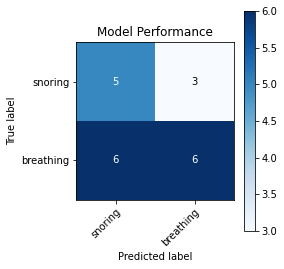

In [30]:
# Plots a confussion matrix
def plot_confusion_matrix(cm,
                          classes, 
                          normalized=False, 
                          title=None, 
                          cmap=plt.cm.Blues,
                          size=(10,10)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalized else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()


y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)


# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)



plot_confusion_matrix(cm,
                          ['snoring','breathing'], 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(4,4))

In [31]:
re = classification_report(y_trues, yhat_probs, labels=[0,1], target_names=['snoring','breathing'])

print(re)

              precision    recall  f1-score   support

     snoring       0.45      0.62      0.53         8
   breathing       0.67      0.50      0.57        12

    accuracy                           0.55        20
   macro avg       0.56      0.56      0.55        20
weighted avg       0.58      0.55      0.55        20



Comparando CNN com SVC (o melhor modelo da etapa anterior):

In [32]:
print(ra1)

              precision    recall  f1-score   support

     snoring       0.75      1.00      0.86         9
   breathing       1.00      0.73      0.84        11

    accuracy                           0.85        20
   macro avg       0.88      0.86      0.85        20
weighted avg       0.89      0.85      0.85        20



De modo geral o SVC obteve melhor desempenho que o CNN, mas ainda assim o resultado poderia ser muito melhor caso tivéssemos uma base maior e assim mais dados para treino.

Coisas para refazer:  

(Conjuntos de teste e treino deveriam ser os mesmos na CNN e no SVM e MLP. No SVM e MLP utilizei o train_test_split e na CNN fiz uma separação diferente.) Utilizar a separação feita na CNN, realizar o reshape e aplicar o SVM e MLP.